In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_peyton_manning.csv')
df$y <- log(df$y)
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.

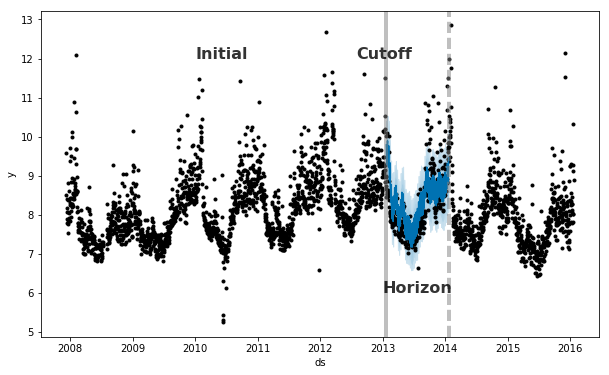

In [3]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(
    m, '365 days', initial='1825 days', period='365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'] == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=cutoff, c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=cutoff + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

[The Prophet paper](https://peerj.com/preprints/3190.pdf) gives further description of simulated historical forecasts.

This cross validation procedure can be done automatically for a range of historical cutoffs using the `cross_validation` function. We specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of `cross_validation` is a dataframe with the true values `y` and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each cutoff date. This dataframe can then be used to compute error measures of `yhat` vs. `y`.

In [4]:
%%R
df.cv <- cross_validation(m, horizon = 730, units = 'days')
head(df.cv)

Initial log joint probability = -53.0208
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
          ds         y     yhat yhat_lower yhat_upper     cutoff
1 2014-01-21 10.542574 9.439116   8.827709  10.077209 2014-01-20
2 2014-01-22 10.004283 9.266698   8.635896   9.888154 2014-01-20
3 2014-01-23  9.732818 9.263058   8.645846   9.861981 2014-01-20
4 2014-01-24  9.866460 9.277099   8.666444   9.847888 2014-01-20
5 2014-01-25  9.370927 9.087197   8.440665   9.734763 2014-01-20
6 2014-01-26  9.490545 9.460199   8.826654  10.070429 2014-01-20


In [5]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon = '730 days')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-21,9.439510,8.799215,10.080240,10.542574,2014-01-20
1,2014-01-22,9.267086,8.645900,9.882225,10.004283,2014-01-20
2,2014-01-23,9.263447,8.628803,9.852847,9.732818,2014-01-20
3,2014-01-24,9.277452,8.693226,9.897891,9.866460,2014-01-20
4,2014-01-25,9.087565,8.447306,9.728898,9.370927,2014-01-20
